# Classification of Driver Distraction

In this project, I aim to develop a deep learning model which can detect and classify different distracted states of drivers in a car. The main approach is to apply deep convolutional neural networks (CNNs). I will explore and experiment various CNN architectures, leveraged pre-trained networks (learning transfer), psuedo labelling, and potentially an emsenbles of several models to find the best classification. Results of this project may be used to further research and applied to as a part of an on-car online monitoring system where computer will decide to take-over control of the car if the driver is distracted and poses a potential accident.

### Using TensorflowGPU mode

In [8]:
from tensorflow.python.client import device_lib

[x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12325561800027376336
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 78616985
locality {
  bus_id: 1
}
incarnation: 12013119733775262870
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Importing all the packages and modules

In [9]:
import math, os, sys
import numpy as np
from numpy.random import random, permutation, randn, normal
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import backend as k
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input,  GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2,l1

import PIL
from PIL import Image
import bcolz
import pickle
from shutil import copyfile
from shutil import move
from glob import glob

Using TensorFlow backend.


In [10]:
%pwd

'C:\\Users\\User\\Downloads\\udacity\\project'

### Creating validation set from training set

In [11]:
current_dir = os.getcwd()
PROJECT_DIR = current_dir
path = current_dir+'/imgs/'
test_path = path + 'test/' #We use all the test data
train_path = path + '/train/'
result_path = path + '/results/'
valid_path = path + '/valid/'

In [12]:
'''
%cd $path
%mkdir valid
%mkdir results
%mkdir models'''

'\n%cd $path\n%mkdir valid\n%mkdir results\n%mkdir models'

In [13]:
"""# Creating validation set
%cd $valid_path
%mkdir c0
%mkdir c1
%mkdir c2
%mkdir c3
%mkdir c4
%mkdir c5
%mkdir c6
%mkdir c7
%mkdir c8
%mkdir c9

%cd $path"""

'# Creating validation set\n%cd $valid_path\n%mkdir c0\n%mkdir c1\n%mkdir c2\n%mkdir c3\n%mkdir c4\n%mkdir c5\n%mkdir c6\n%mkdir c7\n%mkdir c8\n%mkdir c9\n\n%cd $path'

In [14]:
os.listdir(train_path)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [15]:
class_modes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

for i in class_modes:
    print ('label {0} has {1:5d} images'.format(i,len([name for name in os.listdir(train_path+i) if os.path.isfile(os.path.join(train_path+i, name))])))

label c0 has  1989 images
label c1 has  1767 images
label c2 has  1817 images
label c3 has  1846 images
label c4 has  1826 images
label c5 has  1812 images
label c6 has  1825 images
label c7 has  1502 images
label c8 has  1152 images
label c9 has  1238 images


In [16]:
summ = float(0)
for i in class_modes:
    summ=summ+len([name for name in os.listdir(train_path+i) if os.path.isfile(os.path.join(train_path+i, name))])
summ

16774.0

There are around 2000 images for each categories. It is probably a good idea to move 20% of images (400 images for each categories) to validation sets.

In [17]:
%cd $train_path

C:\Users\User\Downloads\udacity\project\imgs\train


# Only run these Once

In [18]:
'''for label in class_modes:
    g = glob(label+"/*.jpg")
    shuffle = np.random.permutation(g)
    for i in range(500):
        move(shuffle[i], valid_path+shuffle[i])'''

'for label in class_modes:\n    g = glob(label+"/*.jpg")\n    shuffle = np.random.permutation(g)\n    for i in range(500):\n        move(shuffle[i], valid_path+shuffle[i])'

# Visulizing the data

Found 5000 images belonging to 10 classes.


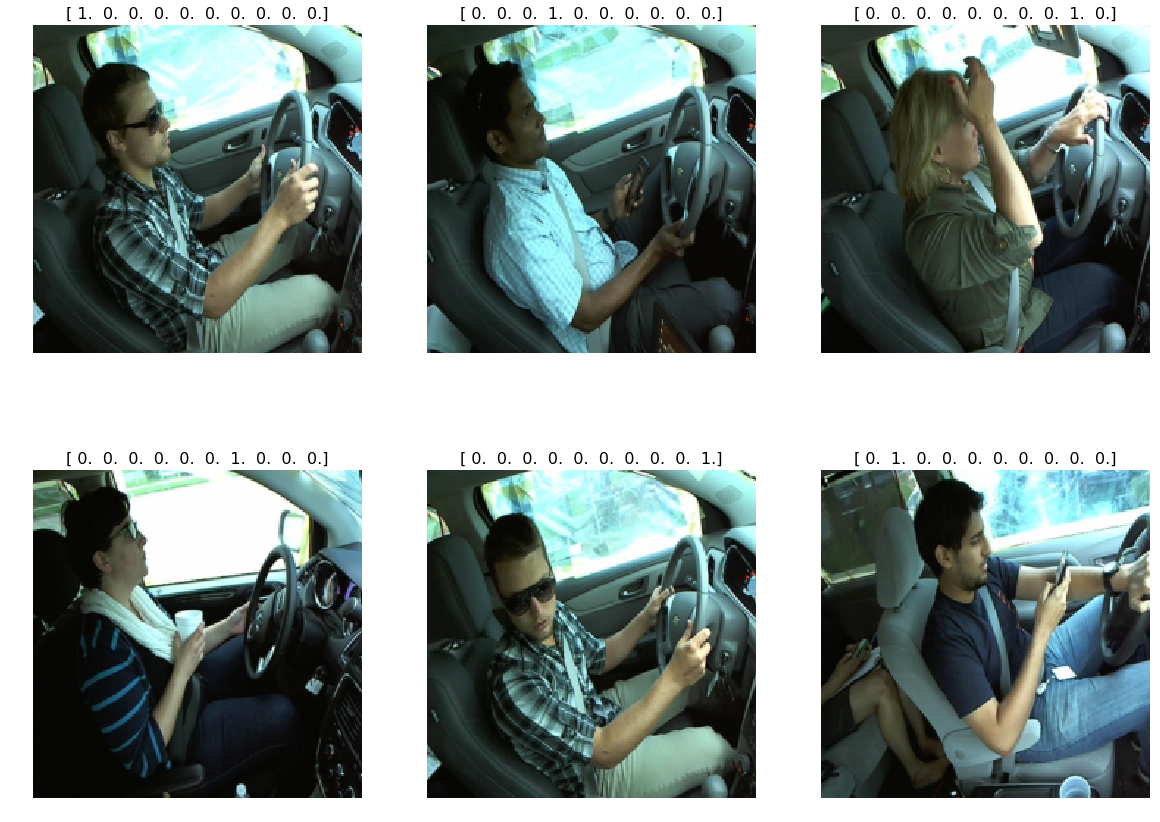

In [19]:
def get_batches(dirname, 
                gen=image.ImageDataGenerator(), 
                shuffle=True,
                batch_size=1, 
                target_size=(224, 224), 
                class_mode = "categorical"):
    
    return gen.flow_from_directory(path+dirname, 
                                   target_size, 
                                   class_mode=class_mode, 
                                   shuffle=shuffle, 
                                   batch_size=batch_size)

def plots(ims, figsize=(12,6), rows=1, titles=True, interp=False):

    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

batches = get_batches("valid", batch_size=6)
imgs , labels = next(batches)
#random images from validation 
plots(imgs, titles=labels, figsize=(20,15), rows =2)

Found 16774 images belonging to 10 classes.


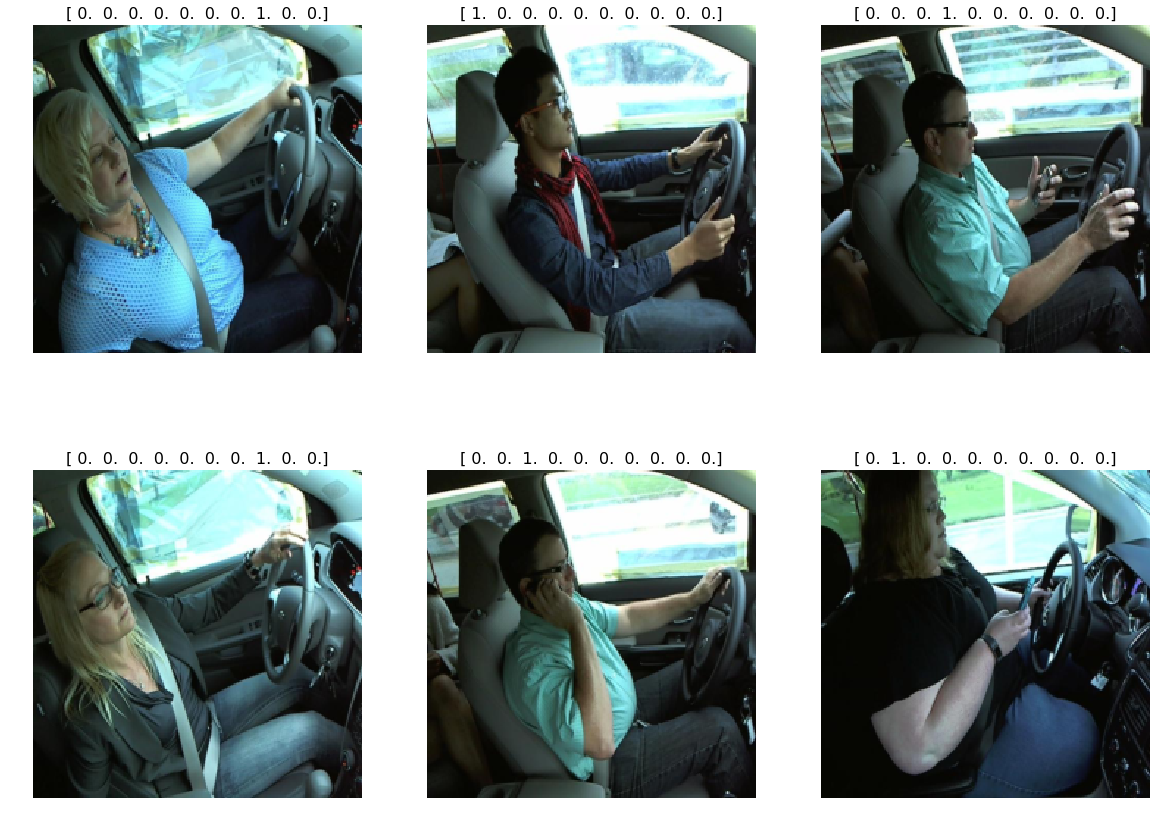

In [20]:
batches = get_batches("train", batch_size=6)
imgs , labels = next(batches)
#random images from training 
plots(imgs, titles=labels, figsize=(20,15), rows =2)

# Get the training and validation data

## Only run these Once

In [22]:
"""def get_data(path, target_size = (224,224)):
    batches = get_batches(path, shuffle=False, batch_size=20, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range (len(batches.classes))])"""

def get_data(path, target_size = (224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range (len(batches.classes))])




#p1 = Process(target=get_data, args=("train",))
#p2 = Process(target=get_data, args=("valid",))
#p1.start()
#p1.join()
#p2.start()
#p2.join()



train_data = get_data("train")
#del train_data
valid_data = get_date("valid")
#del valid_data
#train_data.flush()
#train_data.close()
#valid_data.flush()
#valid_data.close()

Found 16774 images belonging to 10 classes.


NameError: name 'get_date' is not defined

In [ ]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

save_array('results/train_data.dat', train_data)
save_array('results/train_data.dat', train_data)

In [ ]:
def load_array(fname):
    return bcolz.open(fname)[:]

def get_classes(path):
    batches = get_batches('train', shuffle=False, batch_size=1)
    val_batches = get_batches('valid', shuffle=False, batch_size=1)
    #test_batches = get_batches('test', shuffle=False, batch_size=1)
    return (val_batches.classes, batches.classes,to_categorical(val_batches.classes),
            to_categorical(batches.classes),val_batches.filenames, batches.filenames)
           # test_batches.filenames)

(valid_classes, train_classes, valid_labels, train_labels, valid_filenames, train_filenames) = get_classes(path)
valid_data = load_array(path+'results/valid_data.dat')
train_data = load_array(path+'results/train_data.dat')

# 2. Experiements

##  2.1. Benchmark

In this section I will use a fully connected network with no hidden layer, i.e., linear model. This is to provide a benchmark for other experiments developments.

- I used batchnormalization right at the input layer to avoid any domination input values that could skew the output.
- I activated the output with a softmax layer for 10 classes.
- I will use 224x224 input shape, as the results we will have 1.5+ million parametters and easily overfitted with a linear model, hence, l2 regularization is used to minimize impact of overfitting.

In [ ]:
Linear_model = Sequential([
        BatchNormalization(axis=-1, input_shape=(224,224,3)),
        Flatten(),
        Dense(10, activation='softmax')
    ])

Linear_model.compile(Adam(lr=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
Linear_model.summary()

In [ ]:
batch_size=32
Ex1_history = Linear_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5,
                               validation_data =(valid_data,valid_labels))

In [ ]:
def plot_history(Exp_history):
    plt.figure(1)
    plt.subplot(211)
    plt.plot(Exp_history.history['acc'])
    plt.plot(Exp_history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(212)
    plt.plot(Exp_history.history['loss'])
    plt.plot(Exp_history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoches')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig(results_path+'/train_history/Exp_train_history_1.png', bbox_inches='tight')
    plt.show()

plot_history(Ex1_history)

In [ ]:
plot_acc(Ex1_history)

In [ ]:
Linear_model.save_weights(path+'models/Linear_model.h5')

### 2.1.1 Discussion


It can be seen that the linear model with batchnormalization and some l2 regulation actually work pretty well. We can achive validation accuracy of around 94% on the validation dataset. However, the validation accuracy is not stable (even training accuracy is not stable), it means that model will not generalize very well but for starting model, this is very encouraging and it is clearly much better than random guess.

Next we will try to stablize the validation accuracy with convolutional networks.

## 2.2 Simple convolutional layer network

Next, we experiment a neural network with 2 convolutional layers. This experiment will give us an idea on how this dataset behave under convolutional actions. We will try to overfitting and later adding some regularization or data augmentation.

In [ ]:
CNN_simple = Sequential([
            BatchNormalization(input_shape=(224,224,3)),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((3,3)),
            Conv2D(64,(3,3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
        ])

CNN_simple.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
CNN_simple.summary()

In [ ]:
batch_size=32
Ex2_history = CNN_simple.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                             validation_data =(valid_data,valid_labels))

In [ ]:
plot_history(Ex2_history)

In [ ]:
plot_acc(Ex2_history)

In [ ]:
CNN_simple.save_weights(path+'models/CNN_simple.h5')

## 2.3 CNN with dropout layer

In [ ]:
CNN_dropout = Sequential([
        BatchNormalization(input_shape=(224,224,3)),
        Conv2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(128,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
CNN_dropout.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
CNN_dropout.summary()

In [ ]:
batch_size=32
Ex3_history = CNN_dropout.fit(train_data,train_labels, batch_size=batch_size, epochs=2, 
                              validation_data =(valid_data,valid_labels))

In [ ]:
Ex3_history = CNN_dropout.fit(train_data,train_labels, batch_size=batch_size, epochs=3, 
                              validation_data =(valid_data,valid_labels))

In [ ]:
plot_history(Ex3_history)


In [ ]:
plot_acc(Ex3_history)

In [ ]:
CNN_dropout.save_weights(path+'models/CNN_dropout.h5')

## 2.4 CNN with VGG16 model without pre-trained weights

- Preprocessing input data specifically for vgg network
- Put common blocks into functions
- Add batchnormalixation layers (since vgg16 was invented before the introduction of batchnorn , original vgg16 does not contain batchnorm layers)

### 2.4.1 VGG16 model 

### Batches as outputs from vgg16 pretained weights

We will leverage the pre-trained imageNet weights available for vgg16 models.
To do this, it is easier to precompute outputs of vgg16's convolutional part and use these outputs as our inputs to our models. This process will help to save time as well as memory.

In [ ]:
from keras.applications.vgg16 import VGG16
vgg_model_orig = VGG16(weights='imagenet', include_top=True)

Freeze the convolutional part

In [ ]:
# Pop all the layers in Vgg model
layers = vgg_model_orig.layers
# Find all the index of Convolution2D layers
Con2D_layer_idx = [index for index,layer in enumerate(layers) if type(layer) is Conv2D]
# Call the index of the last Convolution2D layer
layer_idx = Con2D_layer_idx[-1]

# Find out what it is
layer_idx

In [ ]:
Con2D_layer_idx

In [ ]:
vgg_model_orig.output.shape

In [ ]:
# Create convolutional model up to layer 30
conv_model = Sequential(layers[:layer_idx+1])
conv_model.summary()

In [ ]:
x = conv_model.output
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x) # output 10 classes
vgg_model = Model(inputs = conv_model.input, outputs = output)

In [ ]:
# Set all the convolutional layers to nontrainable
for layer in conv_model.layers:
    layer.trainable = False
vgg_model.summary()

In [ ]:
vgg_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32
Ex4_history = vgg_model.fit(train_data,train_labels, batch_size=batch_size, epochs=3, 
                              validation_data =(valid_data,valid_labels))

## 2.5 CNN with InceptionV3 model with transfered learning (pretrained weights)

In this experiment, we will use InceptionV3 model with pre-trained imageNet weights. We will first start with the base model with slightly modification of the top layer to adapt with 10 classes instead 1000 classes.

### Base model

In [ ]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(10, activation='softmax')(x) # output 10 classes
IcepV3_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
IcepV3_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
IcepV3_model.summary()

In [ ]:
batch_size=32
Ex4_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=3, 
                              validation_data =(valid_data,valid_labels))

In [ ]:
Ex4_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                              validation_data =(valid_data,valid_labels))

In [ ]:
Ex4_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                              validation_data =(valid_data,valid_labels))

In [ ]:
plot_history(Ex4_history)

In [ ]:
plot_acc(Ex4_history)

In [ ]:
# the first 172 layers and unfreeze the rest:
for layer in IcepV3_model.layers[:172]:
       layer.trainable = False
for layer in IcepV3_model.layers[172:]:
       layer.trainable = True

In [ ]:
IcepV3_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

Ex5_history = IcepV3_model.fit(train_data,train_labels, batch_size=batch_size, epochs=5, 
                              validation_data =(valid_data,valid_labels))

In [ ]:
plot_history(Ex5_history)

In [ ]:
plot_acc(Ex5_history)